<a href="https://colab.research.google.com/github/alfredoaguiararce/rhonn-module-python/blob/main/examples/Robot_Uniciclo_(RHONN_identifier).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Robot movil (tipo uniciclo)

## Analisis matematico

En este primer apartado se realiza la implementacion de las formulas en el apartado <em>IV Aplication: A) Electrically Driven Nonholonomic Mobile Robot</em>.

1. Agregamos las librerias necesarias para el analisis matematico.

In [2]:
import numpy as np  #Facilita el manejo de matrices en Python.
import math         #Agregar las funciones trigonometricas a Python.
import matplotlib.pyplot as plt #Agregar libreria para realizar graficas.

In [3]:
# Clonamos el repositorio
!git clone https://github.com/alfredoaguiararce/rhonn-module-python

# Navegamos a la carpeta creada
%cd rhonn-module-python

# importamos el modulo
from rhonn import rhonn
from rhonn import activation

Cloning into 'rhonn-module-python'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.
/content/rhonn-module-python


2. Definimos algunas funciones que nos permitan no escribir tanto codigo , las funciones implementadas aqui por lo general son segmentos de codigo que se repetian mucho en el codigo, esta es una optimizacion.

In [4]:
def diag(a11, a22):
  """
    Esta funcion regresa una matriz diagonal.
    La matriz se define como :
    [a11 0]
    [0 a22]
  """
  return np.array([[2.5, 0], [0, 2.5]])

def scope(data, x_label = 'x_label', y_label = 'y_label'):
  """
    Esta funcion regresa una grafica sencilla de los datos enviados a travez de 'data'
    por lo tanto data = a un areglo.
    Repreesenta una funcion similar al bloque scope.
  """
  plt.plot(data)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  return plt

def graph_xy(data_x, data_y, x_label = 'x_label', y_label = 'y_label', subtitle = 'subtitle'):
  """
    Esta funcion muestra una grafica sencilla en el plano cartesiano XY
  """
  plt.plot(data_x, data_y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.suptitle('Posiciones de subsitema X1 matriz Jacobiana Jx1')
  return plt

In [5]:
#Ejemplo implementacion de la funcion diag
ejem_1 = diag(2.5,2.5)
#Imprimimos valor e informacion
ejem_1?

3. Definicion de variables del sistema

In [6]:
#Constantes iniciales
#La mitad del ancho del robot mobil.
R = 0.75
#La distancia del centro de Pc del robot mobil a la mitad del punto medio de P0 en medio de las ruedas izquierda y derecha.
d = 0.3
#Radio de la rueda.
r = 0.15
#Masa del cuerpo.
mc = 30
#Masa de la rueda con motor.
mw = 1
#Ic,Iw,Im son los momentos de inercia del cuerpo sobre el eje vertical a traves de Pc.
Ic = 15.625
Iw = 0.005
Im = 0.0025
#Resistencia.
Ra = diag(2.5,2.5)
#Inductancia.
La = diag(0.048,0.048)
#Coeficiente de fuera electromotriz trasero.
KE = diag(0.02,0.02)
#Relacion de transmision.
N = diag(62.55,62.55)
#Constante de torque del motor.
KT = diag(0.2613,0.2613)
#dm1, dm2 son los coeficientes de amortiguamiento.
dm1 = 0.5
dm2 = dm1
D = diag(dm1, dm2)

# Constantes productos de otras constantes%%%%%%%%%%%%%%%%%%%%
m = mc + (2 * mw)
I = (mc * (d ** 2)) + (2 * mw * (R**2)) + Ic + (2*Im)
m11 = 0.25 * ( R ** -2 ) * (r ** 2) * ((m * (R ** 2)) + I) + Iw
m12 = 0.25 * ( R ** -2 ) * (r ** 2) * ((m * (R ** 2)) - I)
M = np.array([[m11, m12], [m12, m11]])

### Configuracion de muestreo

En este apartado se configuran las variables para realizar la simulacion donde:

* tf =  El tiempo total en segundos que dura la simulacion.
* ts = Es el muestreo, o el tiempo en segundos que durara 1 muestra.
* N = El total de muestras existentes de valor ts a lo largo del tiempo tf.
* t = Es un arreglo de tiempo que contiene los segundos para n-esima muestra 

<em>Ejemplo de como se encuentra formado 't'

Para : 
* tf = 180
* ts = 0.2 </em>
* Por lo tanto numero de muestras = (180 / 0.2) = 900 


| No de muestra     | segundos (s) |
| -----------       | ----------- |
| 0                 | 0           |
| 1                 | 0.2         |
| 2                 | 0.4         |
| ...                 | ...        |
| 900                 | 180        |

In [7]:
#Parametros para configurar el tiempo de muestreo en la simulacion asi como los intervalos en los que se realiza.

tf = 180           # Tiempo de simulacion en segundos (s)
ts = 0.2           # Periodo de muestreo en segundos (s)
N = int(180/0.2) #El numero total de muestras
t = np.linspace(0, tf, N)      # Vector de tiempo 0, 0.2, 0.4...

### Simulacion

In [8]:
#del x, y, phi, x11_prediction, x12_prediction, x13_prediction, xp, yp, theta, v1, v2, neurona_X1, neurona_X2, neurona_X3
# Posiciones
xp = [0]
yp = [0]
theta = [0]

# Velocidades
# Velocidad Lineal de la rueda Derecha.
v1_scalar = 0.1;    # m/s
v1 = v1_scalar * np.ones(N)

# Velocidad Lineal de la rueda Izquierda. 
v2_scalar = -0.2    # m/s
v2 = v2_scalar * np.ones(N)

# inicializamos las neuronas X1, X2, X3 Donde:
# X1 = posicion X(k + 1)
# X2 = posicion Y(k + 1)
# X3 = posicion angulo del robot(K + 1)

# Parametros iniciales de las Neuronas.
# Se inicializan los vectores Z y W iniciales para cada neurona
# se debe considerar que Z y W deben tener una longitud igual, o saltara un mensaje de error de parte de la liberia rhonn.

# Especificamente Z representas las entradas iniciales que toma la neurona 
# en este caso Z = [a1, a2]; donde a1 = posicion X inicial, a2 = posicion Y inicial.
Z1 = [0 ,0]
Z2 = [0 ,0]
Z3 = [0 ,0]
# Asi mismo dado la estructura que sigue el algoritmo debe haber 'n' pesos por cada entrada
# siendo este caso W = [w11, w12]
W1 = [0, 0]
W2 = [0, 0]
W3 = [0, 0]

#Los parametros con los que deseamos inicializar el filtro extendido de kalman para cada neurona:
# EKF para X1
P1 = 1 * (10**8)
Q1 = 1 * (10**4)
R1 = 5 * (10**5)

# EKF para X2
P2 = 1 * (10**2)
Q2 = 5 * (10**4)
R2 = 5 * (10**5)

# EKF para X3
P3 = 1 * (10**8)
Q3 = 1 * (10**4)
R3 = 5 * (10**5)

# Definimos los objetos que hacen referencia a las neuronas de la RHONN, 
# se crea una instancia que referencia al objeto, a la cual debemos pasarles sus valores iniciales de W y Z
neurona_X1 =  rhonn(W1, Z1)
# Por defecto si no llamos la funcion '.set_ekf()' automaticamente inicializara los valores iniciales en 0.01
# NOTA: es recomendable modificar estos parametros P,Q,R de manera hueristica.
# En este caso en especifico 0.5 representa el Factor de olvido para un filtro extendido de kalman con factor de olvido, 
# cuando se omite este parametro el factor de olvido se inicializa como 1, de manera que funciona como un filtro extendido de kalman normal.
neurona_X1.set_ekf(P1, Q1, R1, 0.5) 


neurona_X2 = rhonn(W2, Z2)
neurona_X2.set_ekf(P2, Q2, R2)

neurona_X3 = rhonn(W3, Z3)
neurona_X3.set_ekf(P3, Q3, R3)

x = [0]
y = [0]
phi = [0]

x11_prediction = [0]
x12_prediction = [0]
x13_prediction = [0]

for k in  range(N - 1):
    
   
    
    #Vector de Posiciones X1 : >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    positions_array = [[x[k]],[y[k]],[phi[k]]]
    X1 = np.array(positions_array)

    #Vector velocidades X2 en el instante de tiempo k-esimo.>>>>>>>>>>>>>>>>>>>>>>>>>>
    x_21 = v1[k]
    x_22 = v2[k]
    velocity_array = [[x_21],[x_22]]
    #Vector de las velocidades x2 :
    #v1 = Velocidad angular izquierda, 
    #v2 = Velocidad angular derecha.
    X2 = np.array(velocity_array)

    #Matriz Jacobiana J(x1)
    J_x1 = 0.5 * r * np.array([[math.cos(phi[k]), math.cos(phi[k])], [math.sin(phi[k]), math.sin(phi[k])],  [1/R, -1/R]])
    
    #Ecuacion de sub sistema 1. (Modelo cinematico)
    EQ = np.dot(J_x1,X2)

    """
    Integral numerica (Metodo Euler)
    A continuacion se realizan las iteraciones por el metodo de Euler para
    obtener la posicion en el siguiente instante de tiempo.
    Esto se fundamenta dado que la matriz jacobiana por el vector de
    velocidad representan la ecuacion cinematica.
    En resumen al integrar la velocidad podemos encontrar la posicion.
    """
    x.append(x[k]+ts*EQ[0])
    y.append(y[k]+ts*EQ[1])
    phi.append(phi[k]+ts*EQ[2])
    
     # S(x11) , S(x12)
    entradas = [activation.soft_sigmoid(x[k]), activation.soft_sigmoid(y[k])]
    neurona_X1.update(entradas, x[k])
    # S(x11) , S(x12)
    entradas2 = [activation.soft_sigmoid(x[k]), activation.soft_sigmoid(y[k])]
    neurona_X2.update(entradas2, y[k])
    # S(x11) , S(x12)
    entradas3 = [activation.soft_sigmoid(x[k]), activation.soft_sigmoid(y[k])]
    neurona_X3.update(entradas3, phi[k])
    
    
    x11_prediction.append(neurona_X1.predict())
    x12_prediction.append(neurona_X2.predict())
    x13_prediction.append(neurona_X3.predict())
    


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

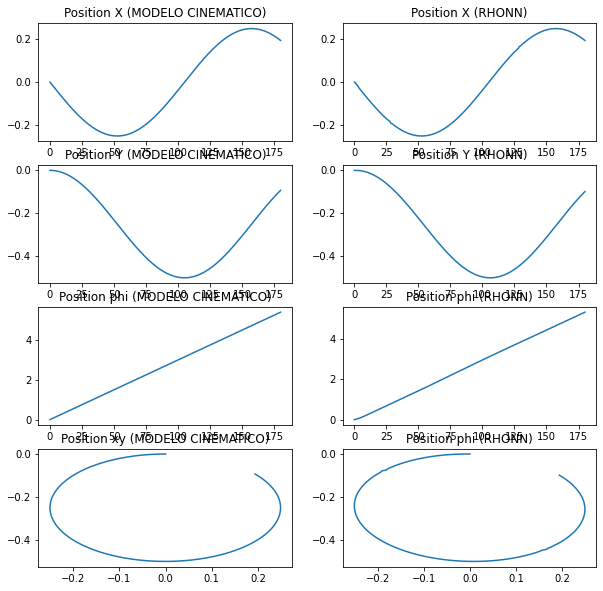

In [9]:
# Inicializamos la grafica
dim_img = 10
plt.rcParams["figure.figsize"] = (dim_img,dim_img)
figure, axis = plt.subplots(4, 2)
  
# Para la grafica de la posicion X
axis[0, 0].plot(t,x)
axis[0, 0].set_title("Position X (MODELO CINEMATICO)")
  
axis[0, 1].plot(t, x11_prediction)
axis[0, 1].set_title("Position X (RHONN)")
  
# Para la grafica de la posicion Y
axis[1, 0].plot(t, y)
axis[1, 0].set_title("Position Y (MODELO CINEMATICO)")
  
axis[1, 1].plot(t, x12_prediction)
axis[1, 1].set_title("Position Y (RHONN)")
   
# Para la grafica de la posicion phi
axis[2, 0].plot(t, phi)
axis[2, 0].set_title("Position phi (MODELO CINEMATICO)")
  
axis[2, 1].plot(t, x13_prediction)
axis[2, 1].set_title("Position phi (RHONN)") 

# Para la grafica de la posicion XY
axis[3, 0].plot(x, y)
axis[3, 0].set_title("Position xy (MODELO CINEMATICO)")
  
axis[3, 1].plot(x11_prediction, x12_prediction)
axis[3, 1].set_title("Position phi (RHONN)")
  
# Combine all the operations and display
plt.show()

## Graficas sobre puestas 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


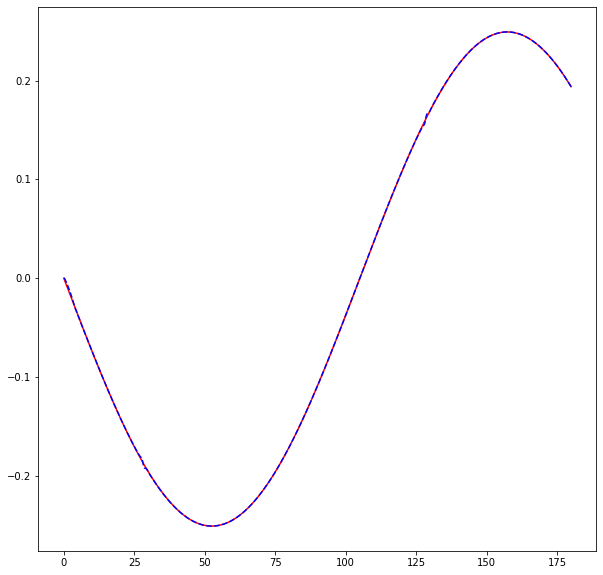

In [11]:
# Posicion en X con 
plt.plot(t, x, 'r') # Posicion en X por modelo cinematico
plt.plot(t, x11_prediction, 'b', linestyle='dashed') # Posicion en X por RHONN con Factor de olvido 0.5

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


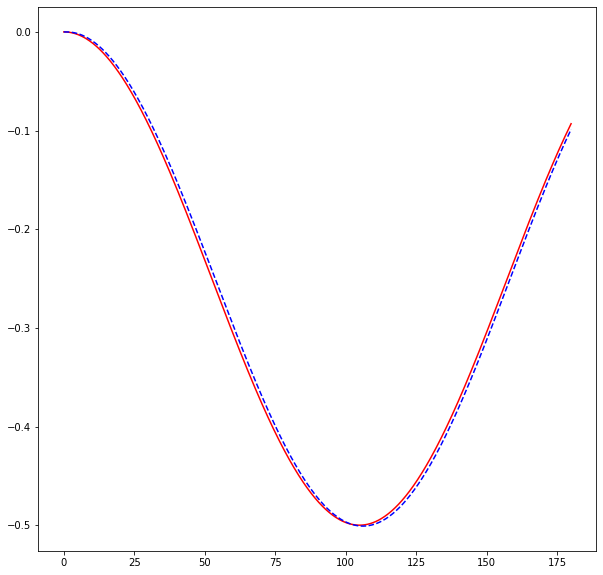

In [12]:
# Posicion en Y con 
plt.plot(t, y, 'r') # Posicion en Y por modelo cinematico
plt.plot(t, x12_prediction, 'b', linestyle='dashed') # Posicion en X por RHONN sin Factor de olvido

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


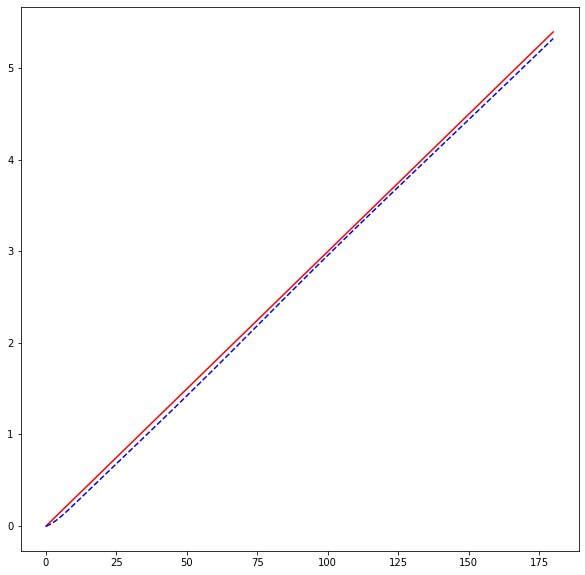

In [13]:
# Posicion en Phi con 
plt.plot(t, phi, 'r') # Posicion en Phi por modelo cinematico
plt.plot(t, x13_prediction, 'b', linestyle='dashed') # Posicion en Phi por RHONN sin Factor de olvido

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


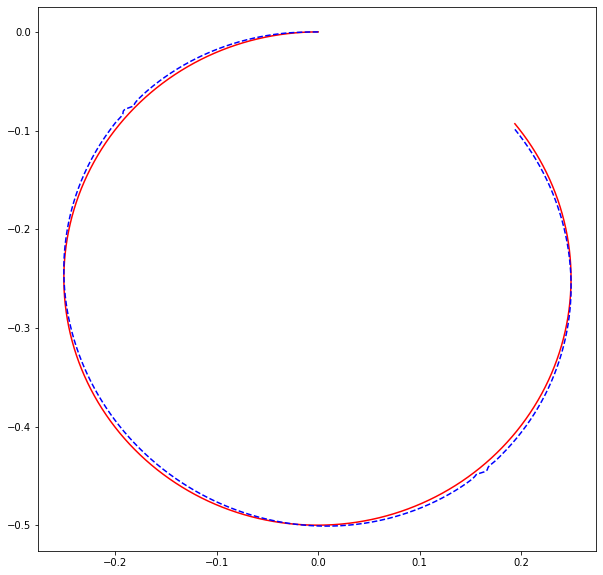

In [14]:
# Posicion en X con 
plt.plot(x, y, 'r') # Posicion en Y por modelo cinematico
plt.plot(x11_prediction, x12_prediction, 'b', linestyle='dashed') # Posicion en X por RHONN sin Factor de olvido